# W4671 Final Project

## Using DNABert to Improve Microbiome OTU clustering for Colorectal Cancer Prediction

## George Austin, gia2105

### Data Setup

In [1]:
# setups
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tqdm


from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import AgglomerativeClustering as AC
from sklearn.inspection import permutation_importance




### DNABERT stuff
import sys
sys.path.append("../DNABERT/examples/data_process_template")
sys.path.append("../DNABERT/examples/")
sys.path.append("../DNABERT/src")
import process_690
import run_pretrain
import run_finetune

### Dataset stuff

#### pulling the reads
kmer = 6
reads_path = '../MicrobiomeHD_data/crc_xiang_results/crc_xiang.otu_seqs.100.fasta'
reads_ = pd.read_csv(reads_path, sep = ',', header = None)


# for the first reads_path

qq = 4

__ = reads_.iloc[range(reads_.shape[0])[1::qq]].reset_index()[0]
for i in range(2, qq):
    __ = __ + reads_.iloc[range(reads_.shape[0])[i::qq]].reset_index()[0]
    
reads_ = pd.DataFrame(\
 {'label':reads_.iloc[range(reads_.shape[0])[::qq]].reset_index()[0] ,\
  'elements':__
  })
reads_['label'] = reads_.label.str[1:]


## getting data in the right format for DNAbert
def kmerify(row):
    return(process_690.get_kmer_sentence( row.elements, kmer=6))


reads_['kmers'] = reads_.apply( kmerify, axis = 1 )


## setting up DNABert model
import argparse
import glob
import logging
import os
import pickle
import random
import re
import shutil
from typing import Dict, List, Tuple
from copy import deepcopy
from multiprocessing import Pool

import torch
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, Dataset, RandomSampler, SequentialSampler
from torch.utils.data.distributed import DistributedSampler

# a lot of this code is from DNABert's repo
from transformers import (
    WEIGHTS_NAME,
    AdamW,
    BertModel,
    BertConfig,
    BertForMaskedLM,
    BertTokenizer,
    DNATokenizer,
    CamembertConfig,
    CamembertForMaskedLM,
    CamembertTokenizer,
    DistilBertConfig,
    DistilBertForMaskedLM,
    DistilBertTokenizer,
    GPT2Config,
    GPT2LMHeadModel,
    GPT2Tokenizer,
    OpenAIGPTConfig,
    OpenAIGPTLMHeadModel,
    OpenAIGPTTokenizer,
    PreTrainedModel,
    PreTrainedTokenizer,
    RobertaConfig,
    RobertaForMaskedLM,
    RobertaTokenizer,
    get_linear_schedule_with_warmup,
)

MODEL_CLASSES = {
    "gpt2": (GPT2Config, GPT2LMHeadModel, GPT2Tokenizer),
    "openai-gpt": (OpenAIGPTConfig, OpenAIGPTLMHeadModel, OpenAIGPTTokenizer),
    "dna": (BertConfig, BertForMaskedLM, DNATokenizer),
    "bert": (BertConfig, BertForMaskedLM, BertTokenizer),
    "roberta": (RobertaConfig, RobertaForMaskedLM, RobertaTokenizer),
    "distilbert": (DistilBertConfig, DistilBertForMaskedLM, DistilBertTokenizer),
    "camembert": (CamembertConfig, CamembertForMaskedLM, CamembertTokenizer),
}


## standard code for loading pretrained huggingface model
config_class, model_class, tokenizer_class = MODEL_CLASSES['dna']

config = config_class.from_pretrained('../DNABERT_model_6/',\
                                      cache_dir='cache/')
config.output_hidden_states = True

tokenizer = tokenizer_class.from_pretrained('../DNABERT_model_6/',\
                                cache_dir='cache/')

model = BertModel.from_pretrained(  '../DNABERT_model_6',
            cache_dir= 'cache/',
            config = config)

<class 'transformers.tokenization_dna.DNATokenizer'>


In [2]:
reads_.tail()

,label,elements,kmers
1612,denovo1613,GTAGTTAGCCGTGGCTTTCTTATAGAGTACCGTCACTTGGATATCA...,GTAGTT TAGTTA AGTTAG GTTAGC TTAGCC TAGCCG AGCC...
1613,denovo1614,GTATTTAGCCGGTGCTTCTTAGTCAGGTACCGTCATTTCTTCTTCC...,GTATTT TATTTA ATTTAG TTTAGC TTAGCC TAGCCG AGCC...
1614,denovo1615,GTAGTTAGCCGGGGCTTCTTAGTCAGGTACCGTCATTTTCTTCCCT...,GTAGTT TAGTTA AGTTAG GTTAGC TTAGCC TAGCCG AGCC...
1615,denovo1616,GTAGTTAGCCGTGGCTTTCTGGTTAGGTACCGTCTCTTATATGTAT...,GTAGTT TAGTTA AGTTAG GTTAGC TTAGCC TAGCCG AGCC...
1616,denovo1617,GTAGTTAGCCGTGGCTTATTCGTTTACTACCGTCATTACAGATCAT...,GTAGTT TAGTTA AGTTAG GTTAGC TTAGCC TAGCCG AGCC...


## Loading OTU Matrix

In [3]:
# reading/set up the otu abundance matrix
path = '../MicrobiomeHD_data/crc_xiang_results/crc_xiang.otu_table.100.denovo'

df = pd.read_csv(path, sep = '\t')
df.index = df[df.columns[0]]
df_fixed = df.drop(df.columns[0], axis = 1).transpose()
df_fixed = df_fixed.div(df_fixed.sum(axis=1), axis=0)
df_fixed = df_fixed[list( df_fixed.columns.dropna() )]
df_fixed = df_fixed[[a for a in reads_.label]]
df_fixed.head()

OTU_ID,denovo1,denovo2,denovo3,denovo4,denovo5,denovo6,denovo7,denovo8,denovo9,denovo10,...,denovo1608,denovo1609,denovo1610,denovo1611,denovo1612,denovo1613,denovo1614,denovo1615,denovo1616,denovo1617
healthy37Xiang,0.000000,0.036029,0.215441,0.091912,0.046324,0.000000,0.047794,0.000000,0.000000,0.022059,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
healthy40Xiang,0.318895,0.018205,0.025110,0.005022,0.030132,0.004394,0.000000,0.082863,0.037665,0.008788,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000628,0.0,0.0
cancer11Xiang,0.113428,0.001668,0.000000,0.153461,0.030859,0.015013,0.000000,0.010008,0.000000,0.033361,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
healthy25Xiang,0.009674,0.000553,0.046434,0.003870,0.027916,0.015202,0.000000,0.003593,0.150636,0.001935,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
cancer8Xiang,0.000000,0.008689,0.005529,0.046603,0.269352,0.184834,0.000000,0.000000,0.000000,0.067141,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0


In [4]:
reads = reads_

## Creating Embeddings

In [5]:
%%time
# n = 20 #doing the encoding in batch size of 20 on cpu
# subsets = [list(reads.kmers)[x:x+n] for x in range(0, len(list(reads.kmers)), n)]
# out = ['']*len(subsets)
# for i in tqdm.tqdm(range(len(subsets))):
#     out[i] = create_embeddings( subsets[i], model, tokenizer)
    
#     if i%10000 == 0 and i > 0:
#         np.save('xiang_embeddings', np.vstack(out[:i]), allow_pickle = True)
        
# embeddings = np.vstack(out)
# np.save('xiang_embeddings', embeddings, allow_pickle = True)

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 4.05 µs


In [6]:
embeddings = np.load('xiang_embeddings.npy')

In [7]:
%%time
from sklearn.metrics import pairwise_distances
sims = 1 - pairwise_distances(embeddings, metric = 'cosine')

CPU times: user 81.7 ms, sys: 19.6 ms, total: 101 ms
Wall time: 100 ms


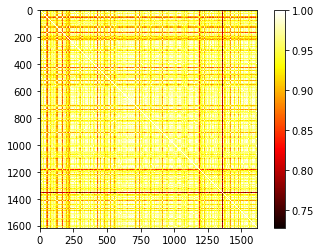

In [8]:
plt.imshow(sims, cmap='hot', interpolation='nearest')
plt.colorbar()
plt.show()

In [9]:
sims

array([[1.        , 0.96940092, 0.99074936, ..., 0.97849061, 0.94571674,
        0.92769263],
       [0.96940092, 1.        , 0.95934332, ..., 0.94694295, 0.93831332,
        0.94699631],
       [0.99074936, 0.95934332, 1.        , ..., 0.98918689, 0.93540968,
        0.90961915],
       ...,
       [0.97849061, 0.94694295, 0.98918689, ..., 1.        , 0.93533431,
        0.89535117],
       [0.94571674, 0.93831332, 0.93540968, ..., 0.93533431, 1.        ,
        0.94993889],
       [0.92769263, 0.94699631, 0.90961915, ..., 0.89535117, 0.94993889,
        1.        ]])

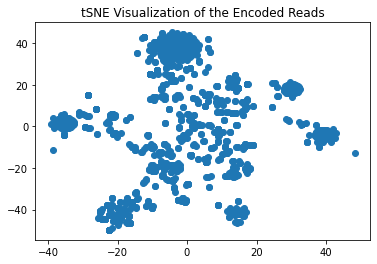

In [10]:
#visualizing representations of the reads
pc = PCA(n_components = 100)
ts = TSNE(n_components = 2, perplexity = 30)

viz = ts.fit_transform( pc.fit_transform(embeddings) )
plt.scatter(viz[:,0], viz[:, 1])
plt.title('tSNE Visualization of the Encoded Reads')
plt.show()

## Load Metadata

In [11]:
# set up prediction task
metadata_path = '../MicrobiomeHD_data/crc_xiang_results/crc_xiang.metadata.txt'

metadata = pd.read_csv(metadata_path, sep = '\t', encoding = 'latin1')

metadata['Var'] = metadata.DiseaseState.fillna('H')
metadata['#Sample ID'] = metadata[metadata.columns[0]]
metadata = metadata[['#Sample ID', 'Var']]
metadata.head()

,#Sample ID,Var
0,cancer1Xiang,CRC
1,cancer2Xiang,CRC
2,cancer3Xiang,CRC
3,cancer4Xiang,CRC
4,cancer5Xiang,CRC


In [12]:
metadata.Var.value_counts()

H      22
CRC    21
Name: Var, dtype: int64

## Test Cluster Performance

In [13]:
from test_models import *

In [14]:
import seaborn as sns
sns.set_theme()

### DNABERT Clusters

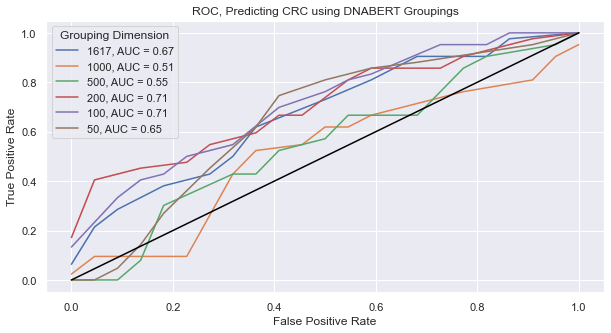

In [15]:
#show performance of DNABert hierarchal clustering
L = []

for i in [df_fixed.shape[1], 1000, 500, 200, 100, 50]:
    L.append( test_reduced_dims(df_fixed, metadata, sims, i, reads) )

full_results = pd.concat([ pd.DataFrame.from_dict( 
    {'fpr':a[0], 
     'tpr':a[1], 
     'auc':[a[2]]*len(a[1]),
     'n_dims':[a[3]]*len(a[1]) } ) \
           for a in L ], axis = 0 )

full_results['Grouping Dimension'] = full_results.n_dims.astype(str) + ', AUC = ' \
                        + full_results.auc.astype(str).str[0:4]

import seaborn as sns
plt.figure(figsize=(10,5))
sns.lineplot(x = 'fpr', y = 'tpr', 
             data = full_results,\
             ci= 0, hue = 'Grouping Dimension') 
plt.plot([0, 1], [0, 1], '-', color = 'black')
plt.title('ROC, Predicting CRC using DNABERT Groupings')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

#### showing LogReg cluster

In [16]:
# Mapping clusters to phylogeny, exploring the cases where the clusters differ,
# and how it relates to interpretable signals from logistic regression

phylos = pd.read_csv('../MicrobiomeHD_data/crc_xiang_results/RDP/crc_xiang.otu_table.100.denovo.rdp_assigned', sep = '\t')['Unnamed: 0']
otu_phylo = pd.DataFrame( \
        dict( {'otu':phylos.str.replace(r';*[a-z]_+', ' ').str.replace(r' +', ' ').str.split(' ').str[-1], 
        'phylogeny':phylos.str.replace(r';*[a-z]_+', ' ').str.replace(r' +', ' ').str.split(' ').str[:-1].str.join(' ') } ) 
          )

#otu_phylo = otu_phylo.loc[otu_phylo.otu.isin(reads.label)].reset_index(drop = True)
# taking dimension of 100, consistently giving good results
clusterer = AC(n_clusters=200, linkage="average", affinity='precomputed')
clusterer.fit(1-sims)
reads['cluster'] = clusterer.labels_

merged_info = otu_phylo.merge(reads, how = 'inner', left_on = 'otu', right_on = 'label')[['otu', 'phylogeny', 'cluster']]


reduced = df_fixed.copy()
reduced.columns = reads.cluster
red = reduced.transpose()
reduced = red.groupby(red.index).sum().transpose()

response = metadata
reduced_resp = reduced.merge(response[['#Sample ID', 'Var']], \
             how = 'inner', 
             left_index = True, right_on = '#Sample ID').drop('#Sample ID', axis = 1)

X = reduced_resp.drop('Var', axis = 1)
y = reduced_resp.Var == pd.DataFrame( response.Var.value_counts() ).index[1]

PREDS = []
TRUES = []

kf = KFold(n_splits=5, random_state=None, shuffle=True)
X = X.reset_index(drop = True)
y = y.reset_index(drop = True)

rf = RandomForestClassifier(n_estimators=100)#penalty = 'l1', solver = 'liblinear')
rf.fit(X, y)

cluster_summaries = merged_info.groupby('cluster')['phylogeny'].agg(lambda x: dict(x.value_counts())).reset_index()

result = permutation_importance(rf, X, y, n_repeats=10,
                                random_state=42, n_jobs=2)
sorted_idx = result.importances_mean.argsort()
print( cluster_summaries.phylogeny[sorted_idx[-1]] )

def get_amount_in_data(row):
    return( (otu_phylo.phylogeny == row ).sum() )

sig_ = cluster_summaries.iloc[sorted_idx[-1]].phylogeny 
[get_amount_in_data(row) for row in sig_.keys()]

{' Bacteria Bacteroidetes Bacteroidia Bacteroidales Bacteroidaceae Bacteroides': 1}


[96]

### Phylogenetic Clusters

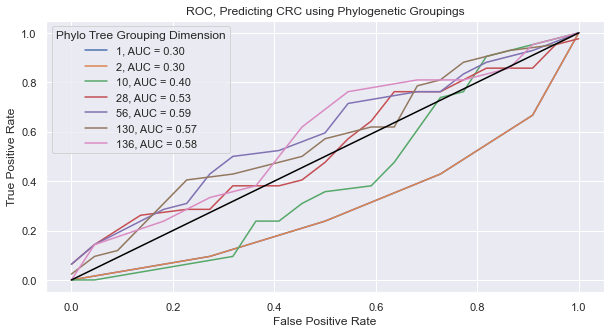

In [17]:
response = metadata  
G = []
for i in [1, 2, 3, 5, 6, 7, 20]:
    G.append( test_reduce_by_phylo_name(df_fixed, response, i, otu_phylo) )
    

phylo_results = pd.concat([ pd.DataFrame.from_dict( 
    {'fpr':a[0], 
     'tpr':a[1], 
     'auc':[a[2]]*len(a[1]),
     'n_cutoffs':[a[3]]*len(a[1]) } ) \
           for a in G ], axis = 0 )

phylo_results['Phylo Tree Grouping Dimension'] = phylo_results.n_cutoffs.astype(str) + ', AUC = ' \
                        + phylo_results.auc.astype(str).str[0:4]


plt.figure(figsize=(10,5))
sns.lineplot(x = 'fpr', y = 'tpr', 
             data = phylo_results,\
             ci= 0, hue = 'Phylo Tree Grouping Dimension') 
plt.plot([0, 1], [0, 1], '-', color = 'black')
plt.title('ROC, Predicting CRC using Phylogenetic Groupings')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

Observations:
- We again see improvements form DNABERT

In [18]:
n_cutoffs = 7
cluster = merged_info.phylogeny.str.split(' ').str[:n_cutoffs].str.join(' ')

reduced = df_fixed.copy()
reduced.columns = cluster
reduced = reduced.transpose().groupby('phylogeny').sum().transpose()
reduced_resp = reduced.merge(response[['#Sample ID', 'Var']], \
             how = 'inner', 
             left_index = True, right_on = '#Sample ID').drop('#Sample ID', axis = 1)

X = reduced_resp.drop('Var', axis = 1)
#print(n_cutoffs, X.shape)
#taking the less common class as the positive response
y = reduced_resp.Var == pd.DataFrame( response.Var.value_counts() ).index[1]

rf = LogisticRegression(penalty = 'l1', solver = 'liblinear')
rf.fit(X, y)

phylo_group_results = pd.DataFrame(dict({ 'phylo':reduced.columns, 
                     'coef':rf.coef_[0] }))

for i in phylo_group_results.loc[phylo_group_results.coef != 0].index:
    print(phylo_group_results.phylo[i])
    print(phylo_group_results.coef[i])



no significant clusters in logreg model for phylo groupings

### Sumaclust Clusters

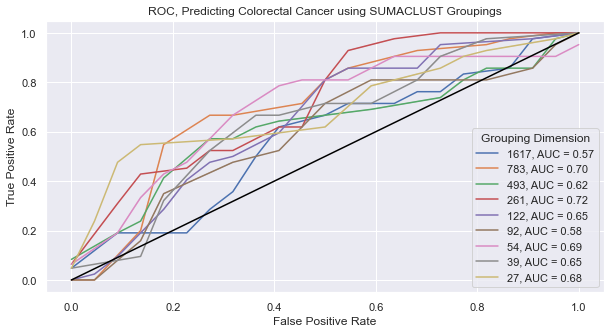

In [19]:
#show performance of sumaclust clustering
L = []
file_path = '../MicrobiomeHD_data/crc_xiang_results/crc_xiang.otu_seqs.100.fasta'
for threshold in [.999, .99, .98, .95, .9, .88, .85, .83, .8]:
    L.append( test_reduced_sumaclust(df_fixed, metadata, threshold, file_path,  reads, f = 'rf') )

sum_results = pd.concat([ pd.DataFrame.from_dict( 
    {'fpr':a[0], 
     'tpr':a[1], 
     'auc':[a[2]]*len(a[1]),
     'n_dims':[a[3]]*len(a[1]) } ) \
           for a in L ], axis = 0 )

sum_results['Grouping Dimension'] = sum_results.n_dims.astype(str) + ', AUC = ' \
                        + sum_results.auc.astype(str).str[0:4]

import seaborn as sns
plt.figure(figsize=(10,5))
sns.lineplot(x = 'fpr', y = 'tpr', 
             data = sum_results,\
             ci= 0, hue = 'Grouping Dimension') 
plt.plot([0, 1], [0, 1], '-', color = 'black')
plt.title('ROC, Predicting Colorectal Cancer using SUMACLUST Groupings')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

## Showing AUCs across clustering methods on one plot

In [20]:
#show performance of sumaclust clustering
L = []
file_path = '../MicrobiomeHD_data/crc_xiang_results/crc_xiang.otu_seqs.100.fasta'
for threshold in list( np.linspace(.75, 1, 30) )*3:
    L.append( test_reduced_sumaclust(df_fixed, metadata, threshold, file_path,  reads, f = 'rf') )

sum_results = pd.concat([ pd.DataFrame.from_dict( 
    {'fpr':a[0], 
     'tpr':a[1], 
     'auc':[a[2]]*len(a[1]),
     'n_dims':[a[3]]*len(a[1]) } ) \
           for a in L ], axis = 0 )

sum_results['Grouping Dimension'] = sum_results.n_dims.astype(str) + ', AUC = ' \
                        + sum_results.auc.astype(str).str[0:4]

In [21]:
L = []

for i in list(np.linspace(25, df_fixed.shape[1], 30, dtype = np.uint64))*3:
               # [df_fixed.shape[1], 500, 200, 100, 50, 40, 25]:
    i = int(i)
    L.append( test_reduced_dims(df_fixed, metadata, sims, i, reads, f = 'rf') )

full_results = pd.concat([ pd.DataFrame.from_dict( 
    {'fpr':a[0], 
     'tpr':a[1], 
     'auc':[a[2]]*len(a[1]),
     'n_dims':[a[3]]*len(a[1]) } ) \
           for a in L ], axis = 0 )

full_results['Grouping Dimension'] = full_results.n_dims.astype(str) + ', AUC = ' \

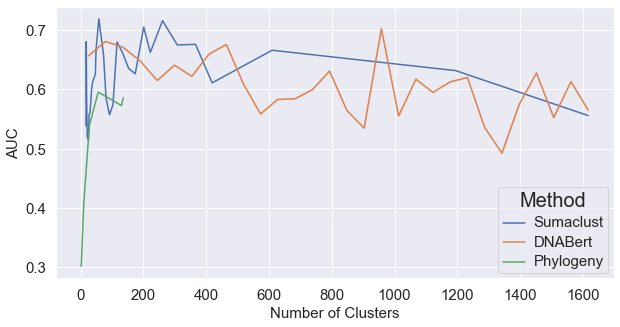

In [22]:
auc_summary = sum_results.groupby('n_dims')['auc'].mean().reset_index()
auc_summary_ = full_results.groupby('n_dims')['auc'].mean().reset_index()
auc_summary['Method'] = 'Sumaclust'
auc_summary_['Method'] = 'DNABert'
phylo_results['n_dims'] = phylo_results.n_cutoffs
auc_summary__ = phylo_results.groupby('n_dims')['auc'].mean().reset_index()
auc_summary__['Method'] = 'Phylogeny'

auc_summary = pd.concat((auc_summary, auc_summary_, auc_summary__), axis = 0)



auc_summary = pd.concat((auc_summary, auc_summary_), axis = 0)
sns.set_theme()
plt.figure(figsize=(10,5))
ax = sns.lineplot(x = 'n_dims', y = 'auc', 
             data = auc_summary,\
             ci= 0, hue = 'Method') 

#plt.title('Comparing Random Forest AUCs across Clustering Methods')
plt.xlabel("Number of Clusters", fontsize = 15)
plt.ylabel("AUC", fontsize = 15)
plt.setp( ax.get_legend().get_texts(), fontsize='15')
plt.setp(ax.get_legend().get_title(), fontsize='20')
ax.tick_params(axis='both', which='major', labelsize=15)
#plt.savefig('Results/crc_xiang_rf.png', pad_inches = 0)
plt.show()